In [1]:
include("../src/KagomeTransport.jl")

using LinearAlgebra
using StaticArrays
using Brillouin
using PlotlyJS
using .KagomeTransport.Kagome_Hamiltonian
using Printf
using LaTeXStrings
using Makie
using GLMakie

In [2]:
assets_dir = "../assets/";

In [3]:
function make_cartesian(vecs, basis)
    """
    Calculates for each v in vectors, v1 * basis[1, :] + v2 * basis[2, :]
        This transforms from the reduced coordinates (w.r.t basis) to the cartesian coordinates 
    """
    cvecs = similar(vecs)
    for (i, v) in enumerate(vecs)
        cvecs[i] = basis' * v
    end
    cvecs
end

function make_reduced(cvecs, basis)
    """
    Calculates for each v in vectors, v1 * basis[1, :] + v2 * basis[2, :]
        This transforms from the reduced coordinates (w.r.t basis) to the cartesian coordinates 
    """
    rvecs = similar(cvecs)
    for (i, v) in enumerate(cvecs)
        rvecs[i] = inv(basis') * v
    end
    rvecs
end

make_reduced (generic function with 1 method)

--- Plotting the Wigner-Seitz cell in real space. 

--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): 
 -0.333333  -0.333333 
 -0.666667   0.333333 
 -0.333333   0.666667 
  0.333333   0.333333 
  0.666667  -0.333333 
  0.333333  -0.666667 

--- Vertices of the real Wigner-Seitz cell (in cartesian coordinates): 
  0.500000   0.288675 
  0.500000  -0.288675 
  0.000000  -0.577350 
 -0.500000  -0.288675 
 -0.500000   0.288675 
  0.000000   0.577350 


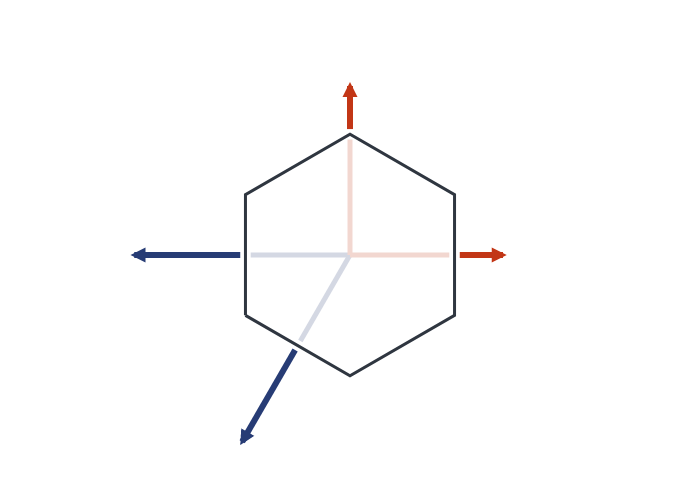

In [4]:
let
    print("--- Plotting the Wigner-Seitz cell in real space. \n")
    print("\n")

    As = [real_basis[i, :] for i ∈ 1 : size(real_basis, 1)]
    real_wignerseitz = wignerseitz(As)

    vertices = real_wignerseitz.verts

    print("--- Vertices of the real Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end

    cvecs = make_cartesian(vertices, As)

    print("\n")
    print("--- Vertices of the real Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cvecs
        @printf("%10f %10f \n", v[1], v[2])
    end

    pbzb = PlotlyJS.plot(real_wignerseitz)
    PlotlyJS.savefig(pbzb, assets_dir * "real_pbzb.png")
    display(pbzb)

end

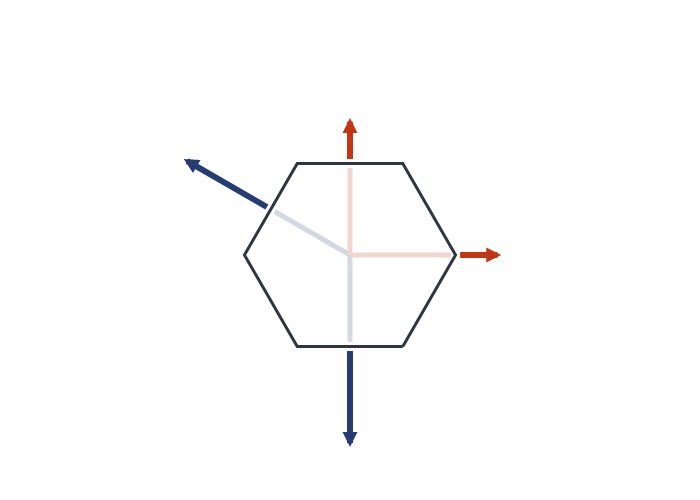

--- Plotting the Wigner-Seitz cell in reciprocal space. 

--- Vertices of the reciprocal Wigner-Seitz cell (in reduced coordinates): 
 -0.333333   0.333333 
 -0.666667  -0.333333 
 -0.333333  -0.666667 
  0.333333  -0.333333 
  0.666667   0.333333 
  0.333333   0.666667 

--- Vertices of the reciprocal Wigner-Seitz cell (in cartesian coordinates): 
  0.333333  -0.577350 
  0.666667   0.000000 
  0.333333   0.577350 
 -0.333333   0.577350 
 -0.666667   0.000000 
 -0.333333  -0.577350 


In [5]:
let 
    print("--- Plotting the Wigner-Seitz cell in reciprocal space. \n")
    print("\n")

    Bs = [recip_basis[i, :] for i ∈ 1 : size(recip_basis, 1)]
    recip_wignerseitz = wignerseitz(Bs)

    vertices = recip_wignerseitz.verts
    print("--- Vertices of the reciprocal Wigner-Seitz cell (in reduced coordinates): \n")
    for v ∈ vertices
        @printf("%10f %10f \n", v[1], v[2])
    end


    cvecs = make_cartesian(vertices, Bs)

    print("\n")
    print("--- Vertices of the reciprocal Wigner-Seitz cell (in cartesian coordinates): \n")
    for v ∈ cvecs
        @printf("%10f %10f \n", v[1], v[2])
    end


    pbzb = PlotlyJS.plot(recip_wignerseitz)
    PlotlyJS.savefig(pbzb, assets_dir * "recip_pbzb.png")
    display(pbzb)
end

In [6]:
# Now, the K-Points 
global const high_symmetry_points = Dict{String, Vector{Float64}}(
    "K"=> [0.6666667, 0.0], 
    "M"=> ([0.3333333, 0.577350] + [0.666666667, 0.0]) / 2.0,
    "Γ"=> [0.0, 0.0] 
)

Dict{String, Vector{Float64}} with 3 entries:
  "M" => [0.5, 0.288675]
  "Γ" => [0.0, 0.0]
  "K" => [0.666667, 0.0]

In [7]:
global const kpath_nodes::Vector{Vector{Float64}} = [high_symmetry_points["Γ"], 
                    high_symmetry_points["K"], 
                    high_symmetry_points["M"], 
                    high_symmetry_points["Γ"]];


In [8]:
# Using the cartesian point "K", apply C_6 symmetry repeatedly to generate the FBZ again
global const C_6::Matrix{Float64} = [cos(pi/3) sin(pi/3); -sin(pi/3) cos(pi/3)]

# Apply matrix n number of times 
function apply(m, v, n)
    res = v
    for i ∈ 1 : n
        res = m * res
    end
    return res
end

function make_fbz_corners()
    corners = Vector{Vector{Float64}}(undef, 6)
    K = high_symmetry_points["K"]
    for n ∈ 0 : 5
        corners[n + 1] = apply(C_6, K, n)
    end
    return corners
end 
global const corners::Vector{Vector{Float64}} = make_fbz_corners()


6-element Vector{Vector{Float64}}:
 [0.6666667, 0.0]
 [0.33333335000000003, -0.5773502980571391]
 [-0.3333333499999998, -0.5773502980571392]
 [-0.6666667, -2.220446049250313e-16]
 [-0.3333333500000002, 0.577350298057139]
 [0.33333334999999964, 0.5773502980571393]

In [9]:
function plot_kpath_fbz(verts, kpath)
    """ 
    Plots the kpath together with the FBZ 
    """
    push!(verts, verts[1])

    # first vertices 
    verts_x = map(v -> v[1], verts)
    verts_y = map(v -> v[2], verts)

    path_x = map(v -> v[1], kpath)
    path_y = map(v -> v[2], kpath)

    # this will just draw the points at the specified coordinates. Need to construct layout object 
    corners_l = PlotlyJS.scatter(x = verts_x, y = verts_y, mode = "lines", opacity = 0.4, line = attr(color = "darkblue", width = 3))
    path_l    = PlotlyJS.scatter(x = path_x, y = path_y, mode = "lines", line = attr(color = "darkgreen", width = 4))

    lo = Layout(title = "Path in the FBZ",
                xaxis_showgrid = false,
                yaxis_showgrid = false,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showline = false, showgrid = false, zeroline = false, showticklabels = false, scaleanchor = "y"),
                yaxis = attr(showline = false, showgrid = false, zeroline = false, showticklabels = false, scaleanchor = "x"),
                width = 510, 
                height = 510,
                showlegend = false)
    PlotlyJS.plot([corners_l, path_l], lo)
    
end

plot_kpath_fbz (generic function with 1 method)

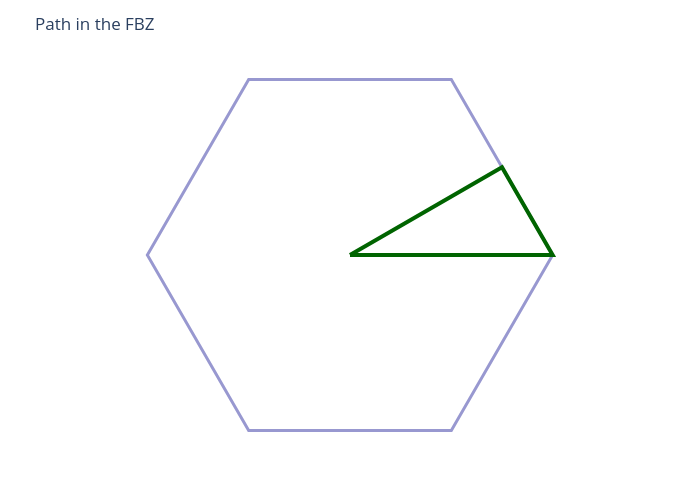

In [10]:
plot_kpath_fbz(corners, kpath_nodes)

In [11]:
# Now, construct the K-Path using linear interpolation. Will directly use the function provided in the Brillouin.jl package 
global const npts_kpath::Int64 = 500
global const kpath_fbz::Vector{Vector{Float64}} = interpolate(kpath_nodes, npts_kpath);
global const kpath_fbz_reduced::Vector{Vector{Float64}} = make_reduced(kpath_fbz, recip_basis);

# In the next part of this notebook, we plot the band structure for the monolayer Kagome model. #

In [12]:
function plot_simple_kagome_bands(p)
    #p = Params()
    eks = evals3.(kpath_fbz_reduced, Ref(p))

    nps_x = size(kpath_fbz_reduced, 1)
    xs = 1 : nps_x
    
    t1 = PlotlyJS.scatter(x = xs, y = map(e->e[1], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t2 = PlotlyJS.scatter(x = xs, y = map(e->e[2], eks), mode = "lines", line = attr(color = "purple", width = 4))
    t3 = PlotlyJS.scatter(x = xs, y = map(e->e[3], eks), mode = "lines", line = attr(color = "purple", width = 4))
    lo = PlotlyJS.Layout(title = "Band Structure",
                xaxis_showgrid = true,
                yaxis_showgrid = true,
                plot_bgcolor="rgba(0,0,0,0)",
                xaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                yaxis = attr(showgrid = true, showticklabels = false, linecolor = "black", linewidth = 5, showline = true, mirror = true),
                width = 510, 
                height = 510,
                showlegend = false)
    
    p = PlotlyJS.plot([t1, t2, t3], lo)
    PlotlyJS.savefig(p, assets_dir * "bands_simple.png")
    display(p)
end

plot_simple_kagome_bands (generic function with 1 method)

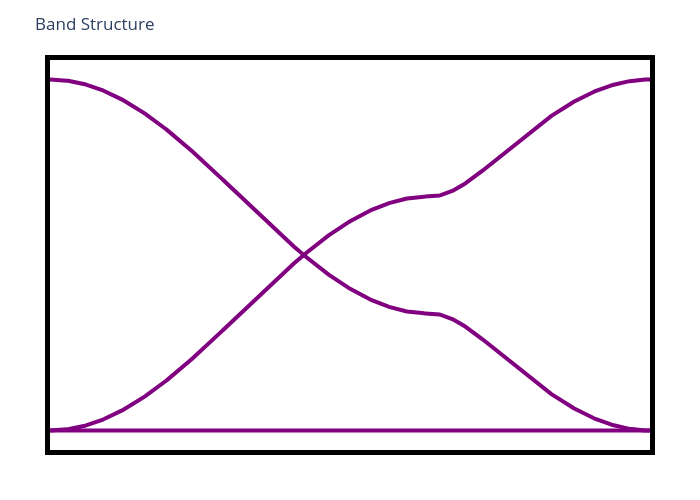

In [13]:
let p0::Params = Params()
    plot_simple_kagome_bands(p0)
end


# Next, consider more general monolayer tight-binding models # 

# Bilayer Kagome Models #